In [1]:
import sys
from pathlib import Path

#Add path to parent folder for imports
sys.path.append(str(Path.cwd().parent))

In [2]:
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.optim as optim
from timebudget import timebudget

def double_conv(in_channels, out_channels):
    '''Performs two successive convolution operations
    '''
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True)
    )
    return conv

def crop_tensor(tensor, target_tensor):
    '''Crop the tensor xdim and ydim.
     - Assumes sizes are divisible by 2
     - Assumes tensor sizes are [batch,channels,xdim,ydim]
    '''
    tensor_size = tensor.size()[2]
    target_tensor_size = target_tensor.size()[2]
    delta = (tensor_size-target_tensor_size)//2
    target = tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]
    return target


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.maxpool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(2, 16)
        self.down_conv_2 = double_conv(16, 32)
        self.down_conv_3 = double_conv(32, 64)
        self.down_conv_4 = double_conv(64, 128)

        self.up_trans_1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv_1 = double_conv(128, 64)

        self.up_trans_2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up_conv_2 = double_conv(64, 32)

        self.up_trans_3 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.up_conv_3 = double_conv(32, 16)

        self.up_trans_4 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.up_conv_4 = double_conv(16, 8)

        self.out = nn.Conv2d(16, 2, kernel_size=1)
        self.sig = nn.Sigmoid()
        return

    def forward(self, image):
        x1 = self.down_conv_1(image)
        #print(x1.size())

        x2 = self.maxpool_2x2(x1)
        x2 = self.down_conv_2(x2)
        #print(x2.size())

        x3 = self.maxpool_2x2(x2)
        x3 = self.down_conv_3(x3)
        #print(x3.size())

        x4 = self.maxpool_2x2(x3)
        x4 = self.down_conv_4(x4)
        #print(x4.size())

        x6 = self.up_trans_1(x4)
        #print(x6.size())
        
        x3 = crop_tensor(tensor=x3, target_tensor=x6)
        x7 = self.up_conv_1(torch.cat(tensors=[x3, x6], dim=1))
        #print(x7.size())
        
        x7 = self.up_trans_2(x7)
        x2 = crop_tensor(tensor=x2, target_tensor=x7)
        x8 = self.up_conv_2(torch.cat(tensors=[x2, x7], dim=1))
        #print(x8.size())

        x8 = self.up_trans_3(x8)
        x1 = crop_tensor(tensor=x1, target_tensor=x8)
        x9 = self.up_conv_3(torch.cat(tensors=[x1, x8], dim=1))
        #print(x9.size())

        x = self.sig(self.out(x9))
        #print(x.size())
        return x

In [13]:
#Test data
from skimage.filters import gaussian
import scipy.io as sio
D = sio.loadmat('../testdata/im260x260.mat',squeeze_me=True)
IM = D['im'].astype(float)

im_0_gauss = gaussian(IM[0,:,:], sigma=3)
im_1_gauss = gaussian(IM[1,:,:], sigma=3)
im_0_gauss = im_0_gauss/np.max(im_0_gauss)
im_1_gauss = im_1_gauss/np.max(im_1_gauss)
L = np.array(np.concatenate([np.expand_dims(im_0_gauss,0),np.expand_dims(im_1_gauss,0)],axis = 0)>0.5).astype('uint8')
L = L.astype(float)

IM_ = np.expand_dims(IM,0)
L_ = np.expand_dims(L,0)

In [14]:
IM_.shape

(1, 2, 260, 260)

In [15]:
L_.shape

(1, 2, 260, 260)

In [3]:
unet = UNet()
optimizer = optim.Adam(unet.parameters())
mse = torch.nn.MSELoss()

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
if cuda:
    unet.cuda()
    mse.cuda()

with timebudget('Training with GPU'):
    for step in range(1000):  # loop over the dataset multiple times
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(Tensor(IM_))
        #loss = torch.sum(torch.square(outputs - )
        target = crop_tensor(Tensor(L_), outputs)
        loss = mse(outputs, target)

        loss.backward()
        optimizer.step()

        # print statistics
        if step % 100 == 0:
            print('Step {:04d} training loss: {:0.6f}'.format(step,loss.item()))

Step 0000 training loss: 0.252556
Step 0100 training loss: 0.065532
Step 0200 training loss: 0.022408
Step 0300 training loss: 0.009913
Step 0400 training loss: 0.005367
Step 0500 training loss: 0.003287
Step 0600 training loss: 0.002214
Step 0700 training loss: 0.001598
Step 0800 training loss: 0.001207
Step 0900 training loss: 0.000943
Training with GPU took 19.550sec


In [4]:
#Checks - plot 
input_size = 260
output_size = 172
crop_size = (input_size-output_size)//2

In [5]:
#tensors have format: [index,channel,height,width]

#Tensors have to be brought to cpu before conversion to numpy
if torch.cuda.is_available():
    lbl = crop_tensor(Tensor(L_), outputs).cpu().numpy()
    img = Tensor(IM_).cpu().numpy()[:,:,crop_size:-crop_size,crop_size:-crop_size]
    pred = outputs.cpu().detach().numpy()
else:
    lbl = crop_tensor(Tensor(L_), outputs).numpy()
    img = Tensor(IM_).numpy()[:,:,crop_size:-crop_size,crop_size:-crop_size]
    pred = outputs.cpu().detach().numpy()

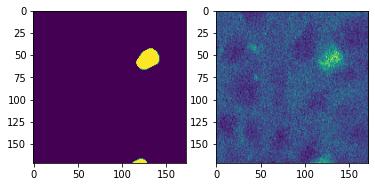

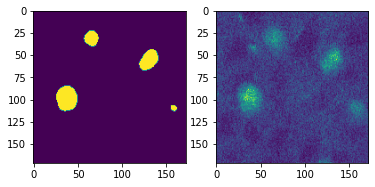

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.subplot(121)
plt.imshow(lbl[0,0,:,:])
plt.subplot(122)
plt.imshow(img[0,0,:,:])

plt.figure()
plt.subplot(121)
plt.imshow(lbl[0,1,:,:])
plt.subplot(122)
plt.imshow(img[0,1,:,:])
plt.show()

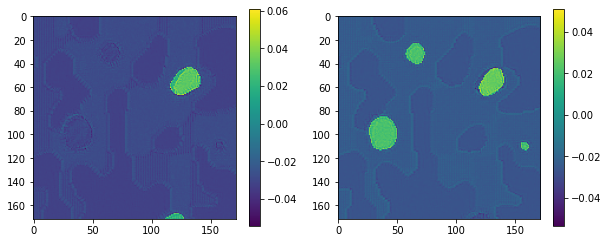

In [7]:
#Checks - plot differences between label and pred
plt.figure(figsize = (10,4))
plt.subplot(121)
plt.imshow(lbl[0,0,:,:]-pred[0,0,:,:])
plt.colorbar()

plt.subplot(122)
plt.imshow(lbl[0,1,:,:]-pred[0,1,:,:])
plt.colorbar()
plt.show()

In [11]:
import numpy as np
from sys import getsizeof
a = [0.0] * 2048 * 2048
b = np.array(a)
getsizeof(a)
sizeim = b.nbytes

print(sizeim/1024/1024, 'Mb per image')
print(40*(sizeim/(1024**3)), 'Gb for 2x for channels + 2x for labels')

32.0 Mb per image
1.25 Gb for 2x for channels + 2x for labels


#### Dataset/dataloader/sampler for full dataset:

In [11]:
import sys
from pathlib import Path
#Add path to parent folder for imports
sys.path.append(str(Path.cwd().parent))

import torch 
torch.manual_seed(0)
from utils.data import ai224_RG, MyRandomSampler
from torch.utils.data import DataLoader


batch_size=12
n_batches_per_epoch=10
num_samples = n_batches_per_epoch*batch_size

train_dataset = ai224_RG(pad=130,
                         patch_size = 260,
                         im_path='/Users/fruity/Dropbox/AllenInstitute/CellCount/dat/raw/Unet_tiles_082020/',
                         lbl_path='/Users/fruity/Dropbox/AllenInstitute/CellCount/dat/proc/Unet_tiles_082020/')

train_sampler = MyRandomSampler(n_tiles=train_dataset.n_tiles, 
                                max_x=train_dataset.tile_shape_orig[0], 
                                max_y=train_dataset.tile_shape_orig[1], 
                                num_samples=num_samples)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,
                            sampler=train_sampler, drop_last=True, pin_memory=True)

train_datagen = iter(train_dataloader)
batch = next(train_datagen)

print(batch['im'].shape)
print(batch['lbl'].shape)

torch.Size([12, 2, 260, 260])
torch.Size([12, 6, 260, 260])


### Testing Transforms
 - https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html

In [12]:
%matplotlib inline
# import torch
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# tensor = lambda x: torch.tensor(x).to(dtype=torch.float32).to(device)
# tensor_ = lambda x: torch.as_tensor(x).to(dtype=torch.float32).to(device)

User warning in torchvision when converting from PIL image to tensor
``` 
/Users/fruity/miniconda3/envs/torch16/lib/python3.7/site-packages/torchvision/transforms/functional.py:109: UserWarning: Given numpy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.as_tensor(np.asarray(pic))
```
  
See for solution:  
- https://github.com/pytorch/vision/issues/2194 
- https://discuss.pytorch.org/t/userwarning-the-given-numpy-array-is-not-writeable/78748/7

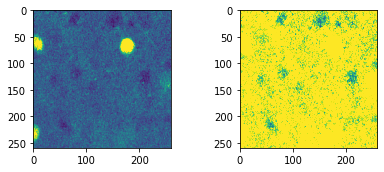

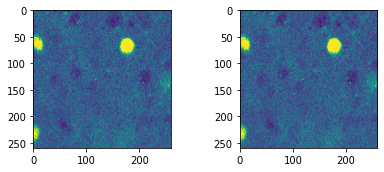

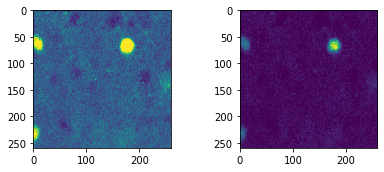

In [13]:
from utils.transforms import My_RandomGamma
for gamma in [0.7,1.0,1.3]:
    gam = My_RandomGamma(p=1.0,gamma_list=[gamma])
    sample = {'im':batch['im'][1],'lbl':batch['lbl'][1]}
    sample_ = gam(sample)

    plt.figure(figsize=(6,2.5))
    plt.subplot(121)
    plt.imshow(np.squeeze(sample['im'].detach().numpy()[0,:,:]),vmin=0,vmax=10)
    plt.subplot(122)
    plt.imshow(np.squeeze(sample_['im'].detach().numpy()[0,:,:]),vmin=0,vmax=10)
    plt.tight_layout()
    plt.show()

In [25]:
from utils.transforms import MyRandomHorizontalFlip
hflip = MyRandomHorizontalFlip(1.0)
sample = {'im':batch['im'][1],'lbl':batch['lbl'][1]}
sample_ = hflip(sample)
plt.figure(figsize=(6,2.5))
plt.subplot(121)
plt.imshow(np.squeeze(sample['im'].detach().numpy()[0,:,:]),vmin=0,vmax=10)
plt.subplot(122)
plt.imshow(np.squeeze(sample_['im'].detach().numpy()[0,:,:]),vmin=0,vmax=10)
plt.tight_layout()
plt.show()

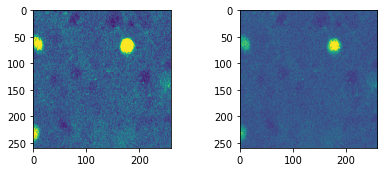

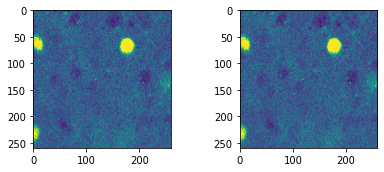

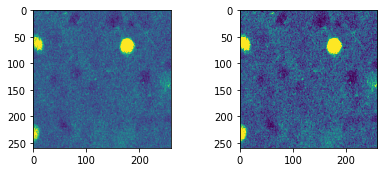

In [15]:
from utils.transforms import My_RandomContrast
for c in [0.5,1.0,1.5]:
    con = My_RandomContrast(p=1.0,contrast_factor_list=[c])
    sample = {'im':batch['im'][1],'lbl':batch['lbl'][1]}
    sample_ = con(sample)

    plt.figure(figsize=(6,2.5))
    plt.subplot(121)
    plt.imshow(np.squeeze(sample['im'].detach().numpy()[0,:,:]),vmin=0,vmax=10)
    plt.subplot(122)
    plt.imshow(np.squeeze(sample_['im'].detach().numpy()[0,:,:]),vmin=0,vmax=10)
    plt.tight_layout()
    plt.show()

### Composing transforms

In [1]:
import sys
from pathlib import Path
#Add path to parent folder for imports
sys.path.append(str(Path.cwd().parent))

import torch 
torch.manual_seed(0)
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from utils.data import ai224_RG, MyRandomSampler
from utils.transforms import MyRandomFlip,My_RandomContrast,My_RandomGamma

In [2]:
batch_size=12
n_batches_per_epoch=10
num_samples = n_batches_per_epoch*batch_size
np_transform = MyRandomFlip(p=1.0)
transforms = Compose([My_RandomContrast(p=1.0,contrast_factor_list=[1.5]),
                      My_RandomGamma(p=1.0,gamma_list=[1.3])])

train_dataset = ai224_RG(pad=130,
                         patch_size = 260,
                         subset = 'train',
                         im_path='/Users/fruity/Dropbox/AllenInstitute/CellCount/dat/raw/Unet_tiles_082020/',
                         lbl_path='/Users/fruity/Dropbox/AllenInstitute/CellCount/dat/proc/Unet_tiles_082020/',
                         np_transform = np_transform,
                         torch_transforms = transforms)

train_sampler = MyRandomSampler(n_tiles=train_dataset.n_tiles, 
                                max_x=train_dataset.tile_shape_orig[0], 
                                max_y=train_dataset.tile_shape_orig[1], 
                                num_samples=num_samples)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,
                            sampler=train_sampler, drop_last=True, pin_memory=True)

train_datagen = iter(train_dataloader)
batch = next(train_datagen)

print(batch['im'].shape)
print(batch['lbl'].shape)

torch.Size([12, 2, 260, 260])
torch.Size([12, 6, 260, 260])


/Users/fruity/miniconda3/envs/torch16/lib/python3.7/site-packages/torchvision/transforms/functional.py:109: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1595629430416/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.as_tensor(np.asarray(pic))


In [ ]:
train_datagen = iter(train_dataloader)
from timebudget import timebudget
with timebudget('10 batches batch'):
    for i in range(10):
        batch = next(train_datagen)

## Updated UNet

In [1]:
from tqdm import tqdm 
import torch
import torch.nn as nn
import torch.optim as optim
from timebudget import timebudget

def double_conv(in_channels, out_channels):
    '''Performs two successive convolution operations
    '''
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(inplace=True)
    )
    return conv

def crop_tensor(tensor, target_tensor):
    '''Crop the tensor xdim and ydim.
     - Assumes sizes are divisible by 2
     - Assumes tensor sizes are [batch,channels,xdim,ydim]
     - Assumes xdim=ydim
    '''
    tensor_size = tensor.size()[-1]
    target_tensor_size = target_tensor.size()[-1]
    delta = (tensor_size-target_tensor_size)//2
    target = tensor[..., delta:tensor_size-delta, delta:tensor_size-delta]
    return target


class UNet2(nn.Module):
    def __init__(self):
        super(UNet2, self).__init__()
        self.maxpool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(2, 16)
        self.down_conv_2 = double_conv(16, 32)
        self.down_conv_3 = double_conv(32, 64)
        self.down_conv_4 = double_conv(64, 128)

        self.up_trans_1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv_1 = double_conv(128, 64)

        self.up_trans_2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up_conv_2 = double_conv(64, 32)

        self.up_trans_3 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.up_conv_3 = double_conv(32, 16)

        self.up_trans_4 = nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2)
        self.up_conv_4 = double_conv(16, 8)

        self.out = nn.Conv2d(16, 6, kernel_size=1)
        self.sig = nn.Sigmoid()
        self.softmax = torch.nn.Softmax(dim=1)
        return

    def forward(self, image):
        x1 = self.down_conv_1(image)
        #print(x1.size())

        x2 = self.maxpool_2x2(x1)
        x2 = self.down_conv_2(x2)
        #print(x2.size())

        x3 = self.maxpool_2x2(x2)
        x3 = self.down_conv_3(x3)
        #print(x3.size())

        x4 = self.maxpool_2x2(x3)
        x4 = self.down_conv_4(x4)
        #print(x4.size())

        x6 = self.up_trans_1(x4)
        #print(x6.size())
        
        x3 = crop_tensor(tensor=x3, target_tensor=x6)
        x7 = self.up_conv_1(torch.cat(tensors=[x3, x6], dim=1))
        #print(x7.size())
        
        x7 = self.up_trans_2(x7)
        x2 = crop_tensor(tensor=x2, target_tensor=x7)
        x8 = self.up_conv_2(torch.cat(tensors=[x2, x7], dim=1))
        #print(x8.size())

        x8 = self.up_trans_3(x8)
        x1 = crop_tensor(tensor=x1, target_tensor=x8)
        x9 = self.up_conv_3(torch.cat(tensors=[x1, x8], dim=1))
        #print(x9.size())
        
        x = self.sig(self.out(x9))

        #x is batch x 6 x height x width        
        #Split along channel dimension, perform softmax for channels independently.
        xg,xr = torch.split(x,[3,3],dim=1)
        xg_norm = self.softmax(xg)
        xr_norm = self.softmax(xr)
        #x = torch.cat([xg,xr],dim=1)
        #print(x.size())
        return xg,xr,xg_norm,xr_norm

In [2]:
import sys
from pathlib import Path
#Add path to parent folder for imports
sys.path.append(str(Path.cwd().parent))

import os
import csv
import torch 
torch.manual_seed(0)
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from utils.data import ai224_RG, MyRandomSampler
from utils.transforms import MyRandomFlip,My_RandomContrast,My_RandomGamma

batch_size=12
patch_size=260
train_pad = int(patch_size/2)
n_batches_per_epoch=10
num_samples = n_batches_per_epoch*batch_size
val_num_samples = 50
im_path = '/home/rohan/Dropbox/AllenInstitute/CellCount/dat/raw/Unet_tiles_082020/'
lbl_path = '/home/rohan/Dropbox/AllenInstitute/CellCount/dat/proc/Unet_tiles_082020/'

result_path = '../'
expt_name = 'testrun/'
expt_path = Path(result_path + expt_name)
expt_path.mkdir(parents=False, exist_ok=True)
log_file = expt_path / 'log.csv'
ckpt_file = lambda epoch: str(expt_path / f'{epoch}_ckpt.pt')

np_transform = MyRandomFlip(p=1.0)
transforms = Compose([My_RandomContrast(p=1.0,contrast_factor_list=[1.5]),
                      My_RandomGamma(p=1.0,gamma_list=[1.3])])

train_dataset = ai224_RG(pad = train_pad,
                         patch_size = patch_size,
                         subset = 'train',
                         im_path=im_path,
                         lbl_path=lbl_path,
                         np_transform = np_transform,
                         torch_transforms = transforms)

train_sampler = MyRandomSampler(n_tiles=train_dataset.n_tiles,
                                min_x=0, min_y=0,
                                max_x=train_dataset.tile_shape_orig[0], 
                                max_y=train_dataset.tile_shape_orig[1], 
                                num_samples=num_samples)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False,
                            sampler=train_sampler, drop_last=True, pin_memory=True)



#Validation data: no padding, only a single, persistent set of validation data.
val_dataset = ai224_RG(pad=0,
                       patch_size = patch_size,
                       subset = 'val',
                       im_path=im_path,
                       lbl_path=lbl_path,
                       np_transform = None,
                       torch_transforms = None)

val_sampler = MyRandomSampler(n_tiles=val_dataset.n_tiles, 
                              min_x=0,
                              min_y=0,
                              max_x=val_dataset.tile_shape_orig[0]-patch_size, 
                              max_y=val_dataset.tile_shape_orig[1]-patch_size, 
                              num_samples=val_num_samples)

val_dataloader = DataLoader(val_dataset, batch_size=val_num_samples, shuffle=False,
                            sampler=val_sampler, drop_last=False, pin_memory=True)

val_datagen = iter(val_dataloader)
val_batch = next(val_datagen)

Found 17 files
Found 3 files


In [3]:
model = UNet2()
best_loss = np.inf
optimizer = optim.Adam(model.parameters())
mse = torch.nn.MSELoss()
ce = torch.nn.CrossEntropyLoss()

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tensor = lambda x: torch.tensor(x).to(dtype=torch.float32).to(device)
tensor_ = lambda x: torch.as_tensor(x).to(dtype=torch.float32).to(device)
tonumpy = lambda x: x.cpu().detach().numpy()

if device.type=='cuda':
    model.cuda()
    mse.cuda()
    ce.cuda()

In [5]:
monitor_loss = []
with timebudget('\nTraining with '+device.type ):
    for epoch in range(500):
        loss_list = []
        train_datagen = iter(train_dataloader)
        for step in range(len(train_dataloader)):
            batch = next(train_datagen)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            xg,xr,xg_norm,xr_norm = model(tensor_(batch['im']))            
            target = crop_tensor(tensor_(batch['lbl']), xg)
            loss = ce(xg, target[:,0,...].type(torch.long)) + \
                   ce(xr, target[:,1,...].type(torch.long))
            
            loss.backward()
            optimizer.step()
            
            loss_list.append(loss.item())
            if (step+1) % len(train_dataloader) == 0: #For last step in every epoch
                #Report average training loss
                train_loss = np.mean(loss_list)
                print('\repoch {:04d} training loss: {:0.6f}'.format(epoch,train_loss),end='')
                
                #Validation=====================================================================
                #torch.no_grad(): Makes evaluation faster. optimizer.zero_grad() part of training step discards gradients.
                model.eval()
                with torch.no_grad():
                    val_xg,val_xr,val_xg_norm,val_xr_norm = model(tensor_(val_batch['im']))
                    val_target = crop_tensor(tensor_(val_batch['lbl']), val_xg)
                    #loss = mse(val_outputs, val_target)
                    val_loss = ce(val_xg, val_target[:,0,...].type(torch.long)) + \
                               ce(val_xr, val_target[:,1,...].type(torch.long))
                    
                val_loss = tonumpy(loss)
                print('\repoch {:04d} validation loss: {:0.6f}'.format(epoch,val_loss),end='')
                model.train()
                
                #Logging
                with open(log_file, "a") as f:
                    writer = csv.writer(f, delimiter=',')
                    if epoch == 0:
                        writer.writerow(['epoch','train_ce','val_ce'])
                    writer.writerow([epoch+1,train_loss,val_loss])
                    
                monitor_loss.append(val_loss)
                
                #Checkpoint
                if (monitor_loss[-1] < best_loss) and epoch>100:
                    best_loss = monitor_loss[-1]
                    torch.save({'epoch': epoch,
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'loss': best_loss,}, ckpt_file(epoch))

/home/rohan/miniconda3/envs/torch16/lib/python3.7/site-packages/torchvision/transforms/functional.py:109: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.as_tensor(np.asarray(pic))


epoch 0499 validation loss: 1.140308
Training with cuda took 470.755sec


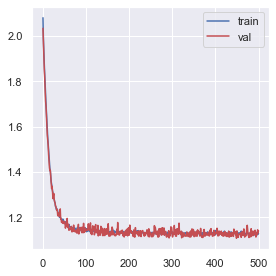

In [6]:
%matplotlib inline
dat = pd.read_csv(log_file)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.figure(figsize=(4,4))
plt.plot(dat['epoch'],dat['train_ce'],'-b',label='train')
plt.plot(dat['epoch'],dat['val_ce'],'-r',label='val')
ax = plt.gca()
plt.legend()
plt.tight_layout()
plt.show()

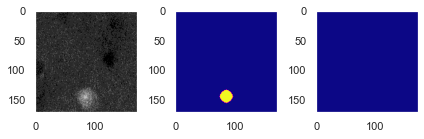

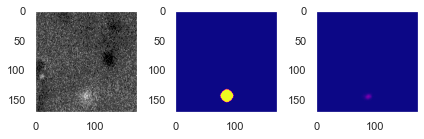

====



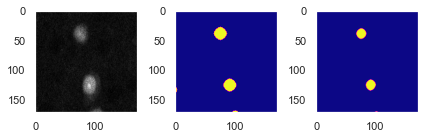

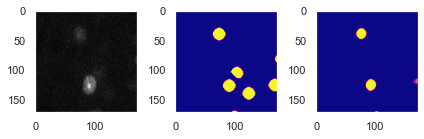

====



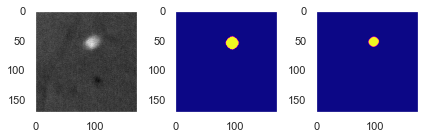

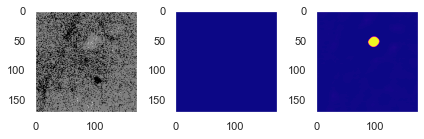

====



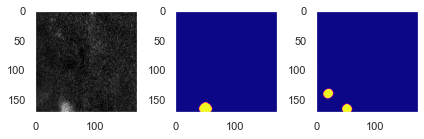

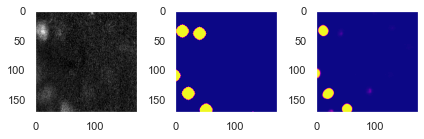

====



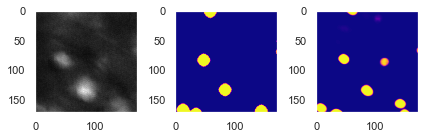

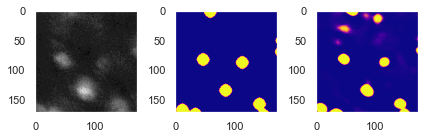

====



In [7]:
%matplotlib inline
#Plot some examples in both channels [image: ground truth: prediction]
for i in [0,1,2,3,4]:
    
    im = tonumpy(crop_tensor(val_batch['im'], val_xg))
    cat = 2
    
    plt.subplot(131)
    plt.imshow(im[i,0],cmap='gray')
    plt.grid(False)
    plt.subplot(132)
    plt.imshow(tonumpy(val_target[:,0,...])[i],vmax=1,vmin=0,cmap='plasma')
    plt.grid(False)
    plt.subplot(133)
    plt.imshow(tonumpy(val_xg)[i,cat],vmax=1,vmin=0,cmap='plasma')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.subplot(131)
    plt.imshow(im[i,1],cmap='gray')
    plt.grid(False)
    plt.subplot(132)
    plt.imshow(tonumpy(val_target[:,1,...])[i],vmax=1,vmin=0,cmap='plasma')
    plt.grid(False)
    plt.subplot(133)
    plt.imshow(tonumpy(val_xr)[i,cat],vmax=1,vmin=0,cmap='plasma')
    plt.grid(False)
    plt.tight_layout()
    plt.show()
        
    print('====\n')

### Prediction
1. File input: .tif 
2. create overlapping patches sequentially (260,260) -> (172,172)

In [8]:
import sys
from pathlib import Path

#Add path to parent folder for imports
sys.path.append(str(Path.cwd().parent))

from torch.utils.data import DataLoader
from utils.data import Pred_ai224_RG, Pred_Sampler


patch_size=260
im_path = '/home/rohan/Dropbox/AllenInstitute/CellCount/dat/raw/Unet_tiles_082020/'

pred_dataset = Pred_ai224_RG(patch_size = patch_size,
                             output_size = 172,
                             im_path=im_path,
                             fname='527100_1027993339_0065_tile_9_8_')

pred_sampler = Pred_Sampler(dataset=pred_dataset)
pred_dataloader = DataLoader(pred_dataset, batch_size=20, shuffle=False,
                            sampler=pred_sampler, drop_last=False, pin_memory=True)

In [9]:
pred_datagen = iter(pred_dataloader)

In [10]:
#Load model from checkpoint
model = UNet2()
checkpoint = torch.load('../test/21_ckpt.pt')
model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']
#loss = checkpoint['loss']

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
tensor = lambda x: torch.tensor(x).to(dtype=torch.float32).to(device)
tensor_ = lambda x: torch.as_tensor(x).to(dtype=torch.float32).to(device)
tonumpy = lambda x: x.cpu().detach().numpy()

if device.type=='cuda':
    model.cuda()

In [11]:
#Create empty tile for labels:
n_labels = 3+3
x_size = pred_dataset.output_size*pred_dataset.n_x_patches
y_size = pred_dataset.output_size*pred_dataset.n_y_patches
output_size = pred_dataset.output_size
lbl = np.empty(shape=[n_labels,x_size, y_size],dtype=float)

In [12]:
#Run model to predict labels
model.eval()
for i in range(len(pred_datagen)):
    batch = next(pred_datagen)
    xg,xr,xg_norm,xr_norm = model(tensor_(batch['im']))
    output = tonumpy(torch.cat([xg,xr],dim=1))
    #breakpoint()
    
    #Loop over patches in each batch
    for j in range(batch['idx'].shape[0]):
        ind = tonumpy(batch['idx'][j])
        lbl[:,ind[0]:ind[0]+output_size,ind[1]:ind[1]+output_size] = output[j]

#Crop labels to original tile size
lbl = lbl[:,:pred_dataset.tile_shape_orig[0],:pred_dataset.tile_shape_orig[1]]

In [13]:
im = np.squeeze(pred_dataset.IM[0][0][pred_dataset.pad_xi:-pred_dataset.pad_xf,pred_dataset.pad_yi:-pred_dataset.pad_yf])

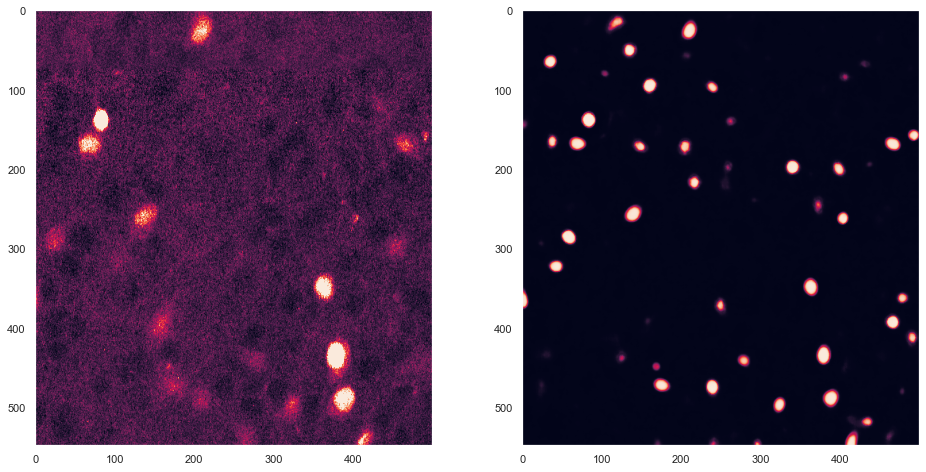

In [14]:
plt.figure(figsize=(16,8))

plt.subplot(121)
plt.imshow(im[1500:,0:500],vmin=0,vmax=10)
plt.grid(False)

plt.subplot(122)
plt.imshow(np.squeeze(lbl[5,1500:,0:500]),vmin=0,vmax=1)
plt.grid(False)
plt.show()